In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.q_network = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_function = nn.MSELoss()

    def choose_action(self, state):
        state_values = list(state.values())
        state_tensor = torch.FloatTensor(state_values).unsqueeze(0)
        q_values = self.q_network(state_tensor)
        action = q_values.argmax().item()
        return action
    
    def learn(self, state, action, reward, next_state, done):
        state_values = list(state.values())  # Convert dictionary values to a list
        next_state_values = list(next_state.values())  # Convert next state values to a list

        state_tensor = torch.FloatTensor(state_values).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state_values).unsqueeze(0)
        q_values = self.q_network(state_tensor)
        next_q_values = self.q_network(next_state_tensor)

        target = q_values.clone()
        target[0][action] = reward + self.gamma * torch.max(next_q_values).item() * (1 - done)

        loss = self.loss_function(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



In [3]:
import pandas as pd
df= pd.read_csv(r'C:\Users\Ayush\OneDrive\Desktop\AI-search-algo\ai-project\datasets\fertilizer_recommendation.csv')
df.head()

c:\Users\Ayush\apython\envs\gpu\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Temparature,Humidity,Soil Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,Sandy,Maize,37,0,0,Urea
1,29,52,45,Loamy,Sugarcane,12,0,36,DAP
2,34,65,62,Black,Cotton,7,9,30,14-35-14
3,32,62,34,Red,Tobacco,22,0,20,28-28
4,28,54,46,Clayey,Paddy,35,0,0,Urea


In [4]:
df['Soil Type'].unique()

array(['Sandy', 'Loamy', 'Black', 'Red', 'Clayey'], dtype=object)

In [5]:
df['Crop Type'].unique()

array(['Maize', 'Sugarcane', 'Cotton', 'Tobacco', 'Paddy', 'Barley',
       'Wheat', 'Millets', 'Oil seeds', 'Pulses', 'Ground Nuts'],
      dtype=object)

In [6]:
crop_mapping = {'Maize': 1, 'Paddy': 0, 'Sugarcane': 2, 'Cotton': 3, 'Tobacco': 4, 'Barley': 5, 'Wheat': 6, 'Millets': 7}
soil_mapping = {'Sandy': 0, 'Loamy': 1, 'Black': 2, 'Red': 3, 'Clayey': 4}

df['Crop Type'] = df['Crop Type'].map(crop_mapping)
df['Soil Type'] = df['Soil Type'].map(soil_mapping)

df.head()

,Temparature,Humidity,Soil Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,0,1.0,37,0,0,Urea
1,29,52,45,1,2.0,12,0,36,DAP
2,34,65,62,2,3.0,7,9,30,14-35-14
3,32,62,34,3,4.0,22,0,20,28-28
4,28,54,46,4,0.0,35,0,0,Urea


In [7]:
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder

class FertilizerEnvironment:
    def __init__(self, initial_state):
        self.state_size = len(initial_state)  # Include all features
        self.state = initial_state
        self.weight_crop_yield = 1.0
        self.weight_nitrogen_reward = 0.8
        self.weight_nutrient_penalty = 0.5
        self.weight_soil_reward = 0.7
        self.best_reward = float('-inf')
        self.last_action = None
        self.available_fertilizers = {
            'Urea': {'nitrogen': 46, 'phosphorous': 0, 'potassium': 0},
            'DAP': {'nitrogen': 18, 'phosphorous': 46, 'potassium': 0},
            '14-35-14': {'nitrogen': 14, 'phosphorous': 35, 'potassium': 14},
            '28-28': {'nitrogen': 28, 'phosphorous': 28, 'potassium': 0},
            '17-17-17': {'nitrogen': 17, 'phosphorous': 17, 'potassium': 17},
            '20-20': {'nitrogen': 20, 'phosphorous': 20, 'potassium': 20}
        }
        self.max_steps = 100
        self.current_step = 0
        self.crop_growth_model = {
            1 : {'nitrogen_slope': 1.5, 'phosphorous_slope': 1.0, 'potassium_slope': 0.8},
            2 : {'nitrogen_slope': 1.2, 'phosphorous_slope': 0.8, 'potassium_slope': 0.6},
            3 : {'nitrogen_slope': 1.0, 'phosphorous_slope': 0.6, 'potassium_slope': 0.5},
            4 : {'nitrogen_slope': 1.3, 'phosphorous_slope': 1.0, 'potassium_slope': 0.7},
            0 : {'nitrogen_slope': 1.4, 'phosphorous_slope': 1.2, 'potassium_slope': 0.9},
            5 : {'nitrogen_slope': 1.2, 'phosphorous_slope': 1.1, 'potassium_slope': 0.7},
            6 : {'nitrogen_slope': 1.3, 'phosphorous_slope': 1.0, 'potassium_slope': 0.8},
            7: {'nitrogen_slope': 1.1, 'phosphorous_slope': 0.9, 'potassium_slope': 0.6},
            8 : {'nitrogen_slope': 1.4, 'phosphorous_slope': 1.2, 'potassium_slope': 0.9}
        }
        self.soil_type_effects = {
            0 : {'nitrogen_effect': 0.8, 'phosphorous_effect': 0.9, 'potassium_effect': 0.7},
            1 : {'nitrogen_effect': 1.0, 'phosphorous_effect': 1.0, 'potassium_effect': 1.0},
            2 : {'nitrogen_effect': 1.2, 'phosphorous_effect': 1.1, 'potassium_effect': 1.1},
            3 : {'nitrogen_effect': 1.1, 'phosphorous_effect': 1.0, 'potassium_effect': 0.9},
            4 : {'nitrogen_effect': 0.9, 'phosphorous_effect': 1.2, 'potassium_effect': 1.3}
        }
        self.optimal_nitrogen_levels = {
            1 : 35,
            2 : 40,
            3 : 30,
            4 : 25,
            0 : 30,
            5 : 35,
            6 : 40,
            7: 30,
            8 : 25
        }

    # def step(self, action):
    #     fertilizer_name = list(self.available_fertilizers.keys())[action]
    #     selected_fertilizer = self.available_fertilizers[fertilizer_name]
    #     updated_state = self.apply_fertilizer(selected_fertilizer)
    #     crop_growth = self.simulate_crop_growth(updated_state)
    #     reward = self.calculate_reward(updated_state, crop_growth)
    #     self.state = updated_state
    #     self.current_step += 1
    #     done = self.current_step >= self.max_steps
    #     return updated_state, reward, done, {}
    
    def step(self, action):
        fertilizer_name = list(self.available_fertilizers.keys())[action]
        selected_fertilizer = self.available_fertilizers[fertilizer_name]
        updated_state = self.apply_fertilizer(selected_fertilizer)
        crop_growth = self.simulate_crop_growth(updated_state)
        reward = self.calculate_reward(updated_state, crop_growth)

        # Keep track of best fertilizer and reward
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_fertilizer = fertilizer_name

        self.state = updated_state
        self.current_step += 1
        done = self.current_step >= self.max_steps
        return updated_state, reward, done, {}
    
    def reset(self):
        self.current_step = 0
        return self.state

    def apply_fertilizer(self, selected_fertilizer):
        updated_state = self.state.copy()
        for nutrient, value in selected_fertilizer.items():
            updated_state[nutrient.lower()] += value
        return updated_state

    def simulate_crop_growth(self, state):
        crop_type = state['crop_type']
        nitrogen_level = state['nitrogen']
        phosphorous_level = state['phosphorous']
        potassium_level = state['potassium']
        soil_type = state['soil_type']
        nitrogen_level *= self.soil_type_effects[soil_type]['nitrogen_effect']
        phosphorous_level *= self.soil_type_effects[soil_type]['phosphorous_effect']
        potassium_level *= self.soil_type_effects[soil_type]['potassium_effect']
        crop_params = self.crop_growth_model.get(crop_type, {})
        crop_yield = 1.0  # Base yield
        if crop_params:
            crop_yield = (18.48*(nitrogen_level * crop_params['nitrogen_slope']) +
                          15.32*(phosphorous_level * crop_params['phosphorous_slope']) +
                          14.98*(potassium_level * crop_params['potassium_slope']))
        crop_yield = min(crop_yield, 1.0)
        crop_growth = {'crop_yield': crop_yield}
        return crop_growth

    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def calculate_reward(self, state, crop_growth):
        crop_yield = crop_growth['crop_yield']
        nitrogen_level = state['nitrogen']
        phosphorous_level = state['phosphorous']
        potassium_level = state['potassium']
        soil_type = state['soil_type']
        optimal_nitrogen = self.optimal_nitrogen_levels.get(state['crop_type'], 0)
        deviation = abs(nitrogen_level - optimal_nitrogen)
        nitrogen_reward = max(0, 1.0 - deviation / optimal_nitrogen)
        # if random.random() < 0.2:  # Randomly modify reward
        #     nitrogen_reward += random.uniform(-0.2, 0.2)
        phosphorous_penalty = max(0, phosphorous_level - 30) / 30.0 
        phosphorous_penalty = 1 - (1 - phosphorous_penalty) ** 2
        potassium_penalty = max(0, potassium_level - 20) / 20.0 
        potassium_penalty = 1 - (1 - potassium_level) ** 2
        nutrient_penalty = 1.0 - (phosphorous_penalty + potassium_penalty)
        soil_reward = self.soil_type_effects[soil_type]['nitrogen_effect'] + self.soil_type_effects[soil_type]['phosphorous_effect'] + self.soil_type_effects[soil_type]['potassium_effect']
        reward = (self.weight_crop_yield * crop_yield +
                  self.weight_nitrogen_reward * nitrogen_reward +
                  self.weight_nutrient_penalty * nutrient_penalty +
                  self.weight_soil_reward * soil_reward)
        print(f'Reward: {reward:.2f} (Crop Yield: {crop_yield:.2f}, Nitrogen Reward: {nitrogen_reward:.2f}, Nutrient Penalty: {nutrient_penalty:.2f}, Soil Reward: {soil_reward:.2f})')
        return reward

In [8]:
# Usage example and training loop
initial_state = {
    'temperature': 26,
    'humidity': 52,
    'soil_moisture': 38,
    'soil_type': soil_mapping['Loamy'],
    'crop_type': crop_mapping['Maize'],
    'nitrogen': 37,
    'phosphorous': 0,
    'potassium': 0
}


c:\Users\Ayush\apython\envs\gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def train_model(initial_state, num_episodes=10, max_steps_per_episode=100):
    # Create the environment
    env = FertilizerEnvironment(initial_state)

    # Create the DQN agent
    input_size = len(initial_state)
    output_size = len(env.available_fertilizers)
    agent = DQNAgent(input_size, output_size)

    # Define lists to store episode rewards and best results
    episode_rewards = []
    best_rewards = []
    best_fertilizers = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        for step in range(max_steps_per_episode):
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            episode_reward += reward
            state = next_state

            if done:
                break

        # Store episode reward
        episode_rewards.append(episode_reward)

        # Store best result and corresponding fertilizer
        best_rewards.append(env.best_reward)
        best_fertilizers.append(env.best_fertilizer)

        # Print episode statistics
        print(f"Episode {episode + 1}: Total Reward: {episode_reward}")
    # Plot episode rewards
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_episodes + 1), episode_rewards, label='Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_episodes + 1), best_rewards, label='Best Result')
    plt.xlabel('Episode')
    plt.ylabel('Best Result')
    plt.title('Best Result over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

Reward: 183.90 (Crop Yield: 1.00, Nitrogen Reward: 0.37, Nutrient Penalty: 361.00, Soil Reward: 3.00)
Reward: 763.32 (Crop Yield: 1.00, Nitrogen Reward: 0.00, Nutrient Penalty: 1520.44, Soil Reward: 3.00)
Reward: 1743.10 (Crop Yield: 1.00, Nitrogen Reward: 0.00, Nutrient Penalty: 3480.00, Soil Reward: 3.00)
Reward: 3123.32 (Crop Yield: 1.00, Nitrogen Reward: 0.00, Nutrient Penalty: 6240.44, Soil Reward: 3.00)
Reward: 4903.99 (Crop Yield: 1.00, Nitrogen Reward: 0.00, Nutrient Penalty: 9801.78, Soil Reward: 3.00)
Reward: 7085.10 (Crop Yield: 1.00, Nitrogen Reward: 0.00, Nutrient Penalty: 14164.00, Soil Reward: 3.00)
Reward: 9666.66 (Crop Yield: 1.00, Nitrogen Reward: 0.00, Nutrient Penalty: 19327.11, Soil Reward: 3.00)
Reward: 12648.66 (Crop Yield: 1.00, Nitrogen Reward: 0.00, Nutrient Penalty: 25291.11, Soil Reward: 3.00)
Reward: 16031.10 (Crop Yield: 1.00, Nitrogen Reward: 0.00, Nutrient Penalty: 32056.00, Soil Reward: 3.00)
Reward: 19813.99 (Crop Yield: 1.00, Nitrogen Reward: 0.00, Nu

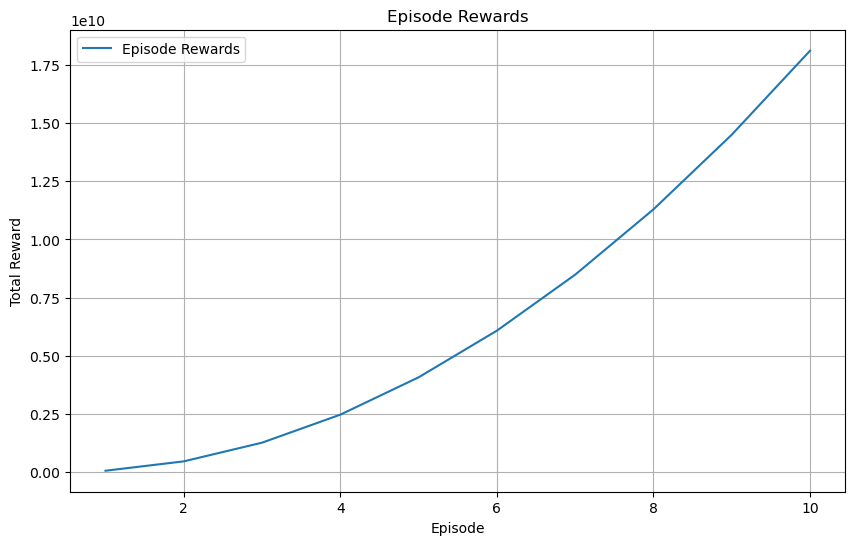

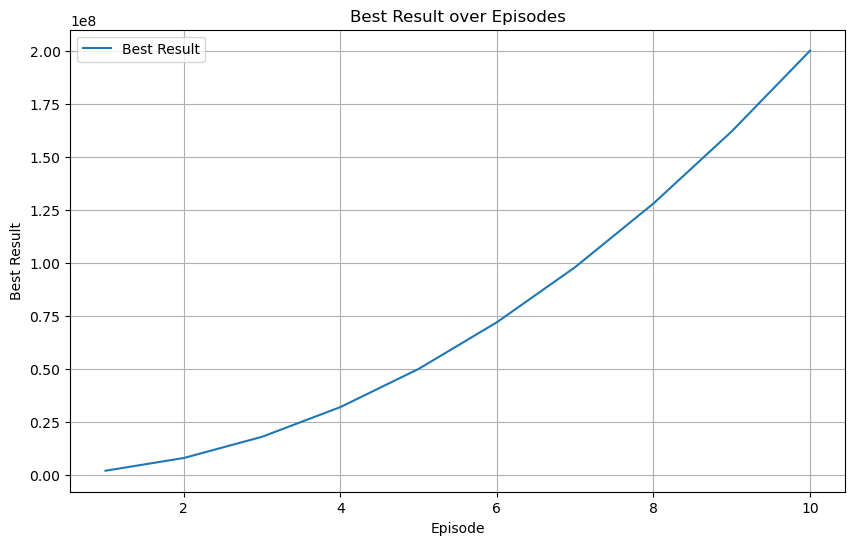

In [13]:
train_model(initial_state, num_episodes=10, max_steps_per_episode=100)

In [14]:
best_fertilizers

['28-28',
 '28-28',
 '28-28',
 '28-28',
 '28-28',
 '28-28',
 '28-28',
 '28-28',
 '28-28',
 '28-28']